In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils)

<module 'LearningCutsUtils' from '/home/mhance/CABIN/LearningCutsUtils/__init__.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars
import LearningCutsUtils.Utils as LCU

In [4]:
N=20000 # number of points
m=10 # dimensions

In [5]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

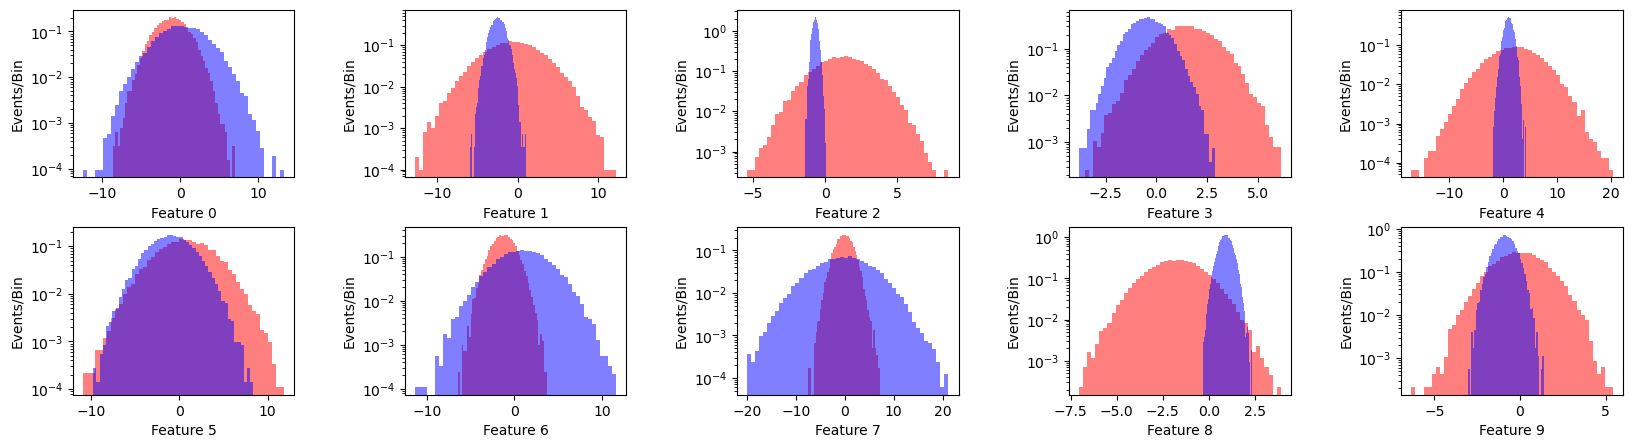

In [6]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [8]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [9]:
gt=1.
lt=-1.
cuts_gt_lt = []
if m==10:
    cuts_gt_lt = [lt, gt, gt, gt, lt,
                  gt, lt, lt, lt, gt]
elif m==5:
    cuts_gt_lt = [lt, gt, gt, gt, gt]

In [10]:
targeteffics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=25

# how we scale the inputs to the activation function.
# larger values improve the matching of the signal efficiency
# calculated in the loss function and the efficiency that we
# see when applying the cuts.
activation_input_scale_factor=15

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
delta    = 1e-6  # scaling factor for how much to use BCE loss to optimize
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [11]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [12]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, delta, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, delta, epsilon)        
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'net_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  1.0s, Train loss=2.7e+01, Test loss=2.7e+01
Completed epoch  1 in  0.7s, Train loss=2.7e+01, Test loss=2.6e+01
Completed epoch  2 in  0.8s, Train loss=2.6e+01, Test loss=2.4e+01
Completed epoch  3 in  0.8s, Train loss=2.4e+01, Test loss=2.0e+01
Completed epoch  4 in  0.7s, Train loss=2.0e+01, Test loss=1.4e+01
Completed epoch  5 in  0.8s, Train loss=1.4e+01, Test loss=7.9e+00
Completed epoch  6 in  0.8s, Train loss=8.1e+00, Test loss=4.4e+00
Completed epoch  7 in  0.7s, Train loss=4.5e+00, Test loss=2.5e+00
Completed epoch  8 in  0.8s, Train loss=2.6e+00, Test loss=1.6e+00
Completed epoch  9 in  0.7s, Train loss=1.6e+00, Test loss=9.9e-01
Completed epoch 10 in  0.7s, Train loss=1.0e+00, Test loss=6.7e-01
Completed epoch 11 in  0.7s, Train loss=7.0e-01, Test loss=4.8e-01
Completed epoch 12 in  0.7s, Train loss=5.0e-01, Test loss=3.6e-01
Completed epoch 13 in  0.7s, Train loss=3.8e-01, Test loss=2.8e-01
Completed epoch 14 in  0.8s, Train loss=3.0e-01, Test loss=2.3

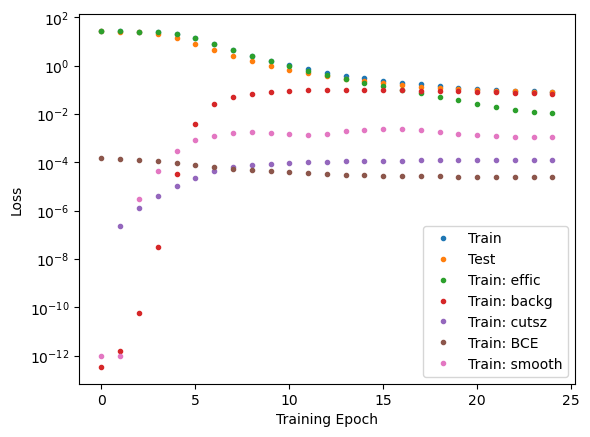

In [13]:
LCU.plotlosses(losses,losses_test)

In [14]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LCU.check_effic(x_test_tensor,y_test,net.nets[n],True)

    # check that after reloading the weights we still get the same performance after pretraining
    net.nets[n].eval() # configure the model for evaluation (testing)
    y_pred = net.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor, m, net.nets[n], targeteffics[n], alpha, beta, gamma, delta, True)
    print("------------")

Target efficiency: 20.0%
Signal     efficiency with net outputs: 20.6%
Background efficiency with net outputs:  0.00000%
Inspecting efficiency loss: alpha=10.0, target=0.200, subnet_effic=0.2002, subnet_backg=0.0003, efficloss=6.154e-07, backgloss=2.635e-05
------------
Target efficiency: 30.0%
Signal     efficiency with net outputs: 31.0%
Background efficiency with net outputs:  0.55193%
Inspecting efficiency loss: alpha=10.0, target=0.300, subnet_effic=0.3027, subnet_backg=0.0056, efficloss=7.203e-05, backgloss=5.637e-04
------------
Target efficiency: 40.0%
Signal     efficiency with net outputs: 40.8%
Background efficiency with net outputs:  1.65580%
Inspecting efficiency loss: alpha=10.0, target=0.400, subnet_effic=0.4019, subnet_backg=0.0193, efficloss=3.524e-05, backgloss=1.928e-03
------------
Target efficiency: 50.0%
Signal     efficiency with net outputs: 50.5%
Background efficiency with net outputs:  2.70948%
Inspecting efficiency loss: alpha=10.0, target=0.500, subnet_effic

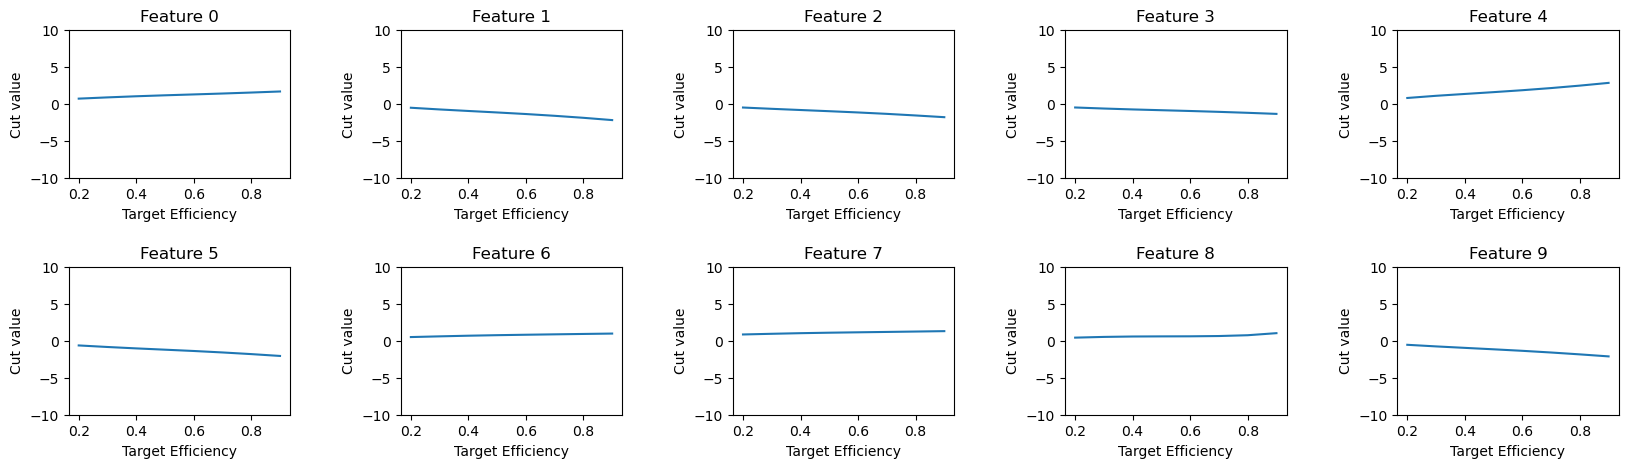

In [15]:
# Distributions of cuts
LCU.plotgenericcuts(net)

Target efficiency: 20.0%


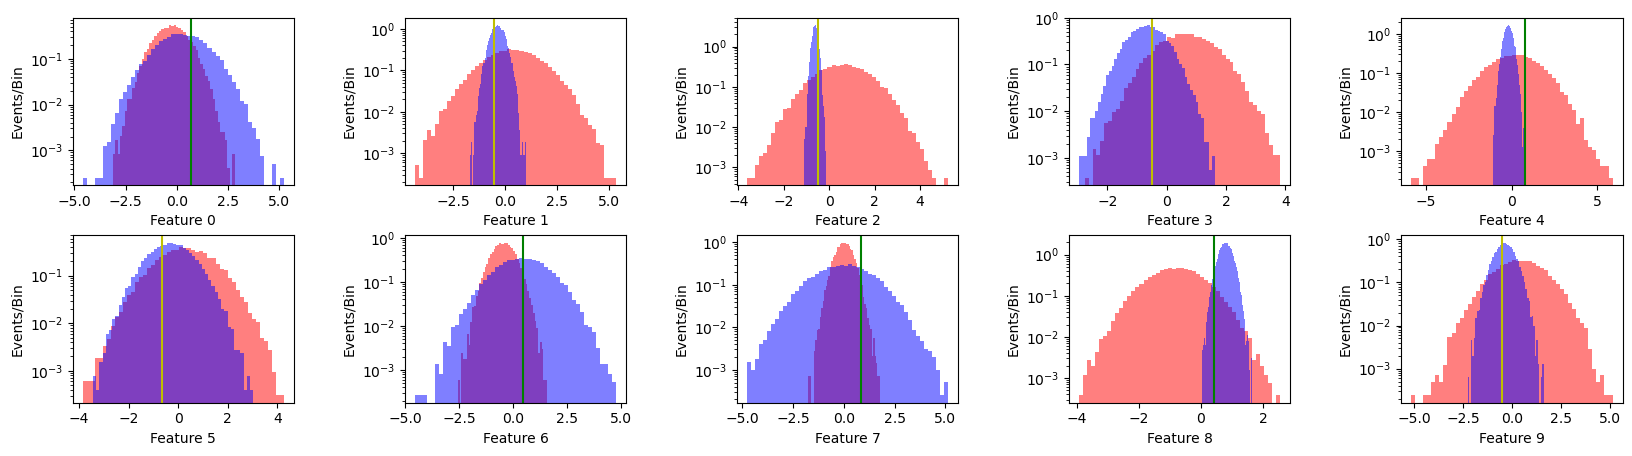

Target efficiency: 30.0%


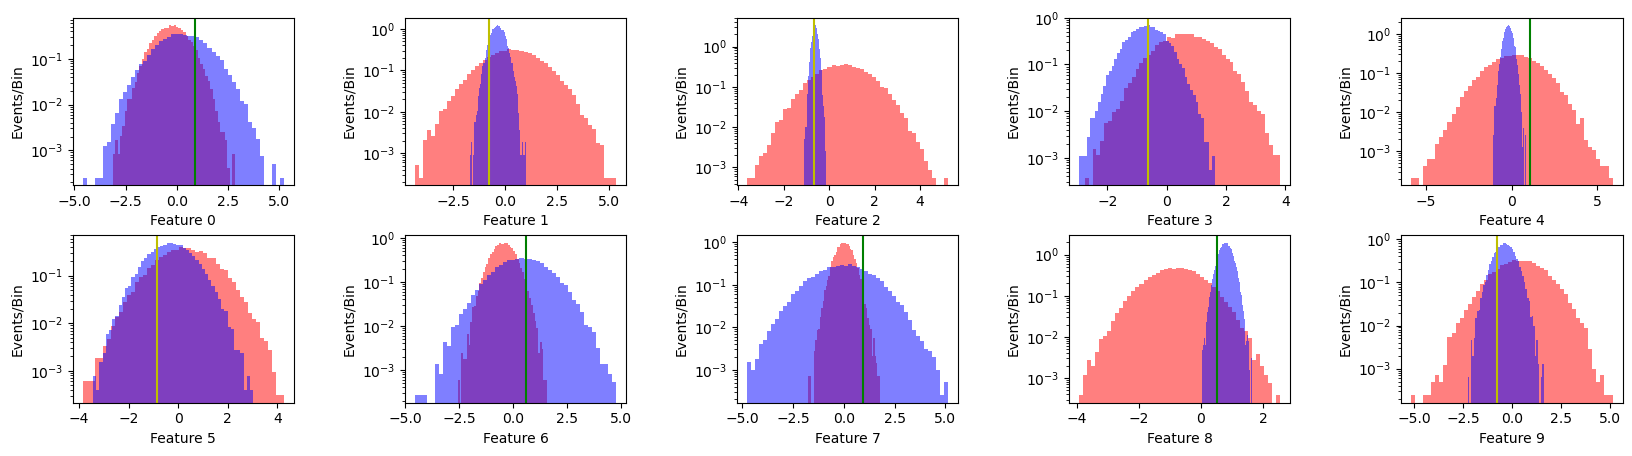

Target efficiency: 40.0%


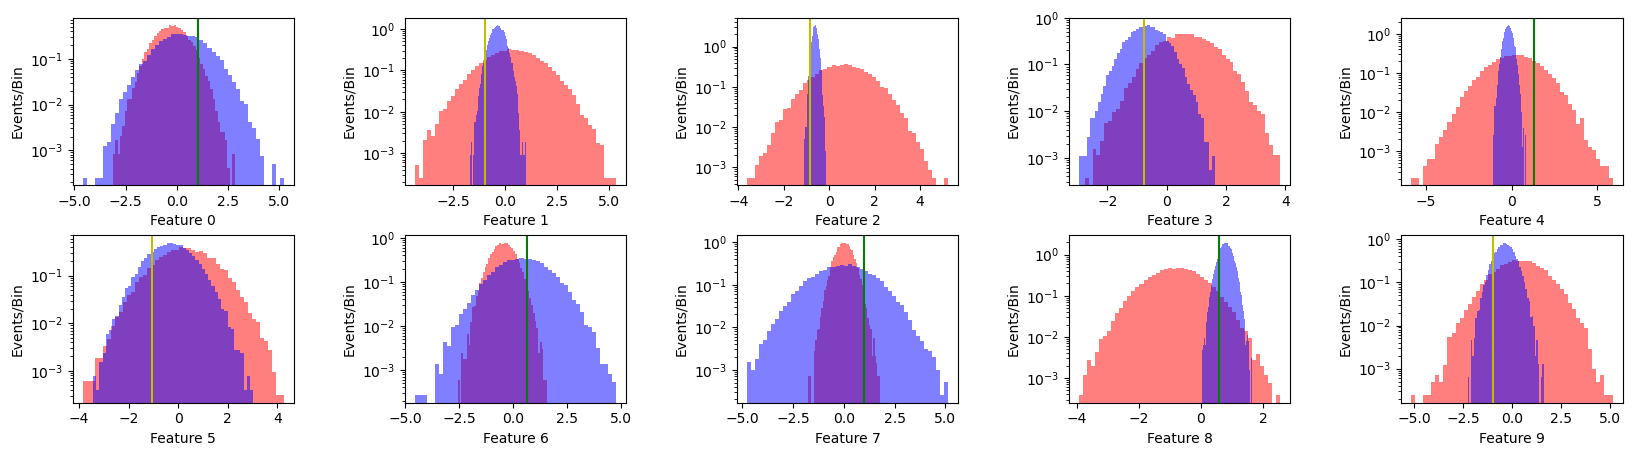

Target efficiency: 50.0%


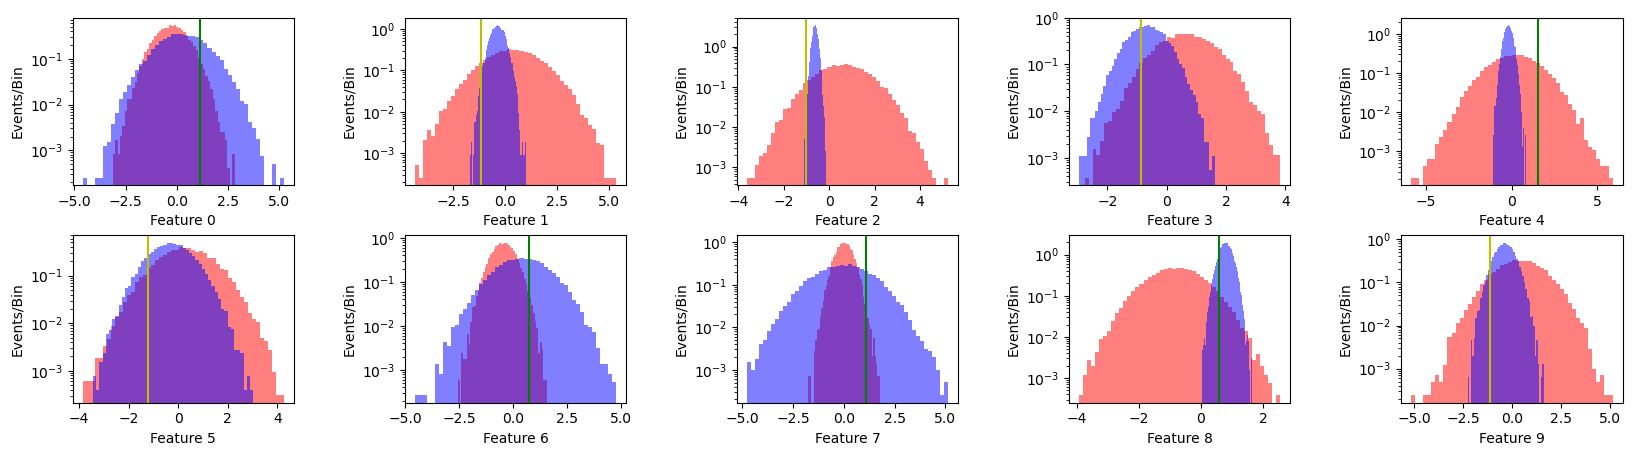

Target efficiency: 60.0%


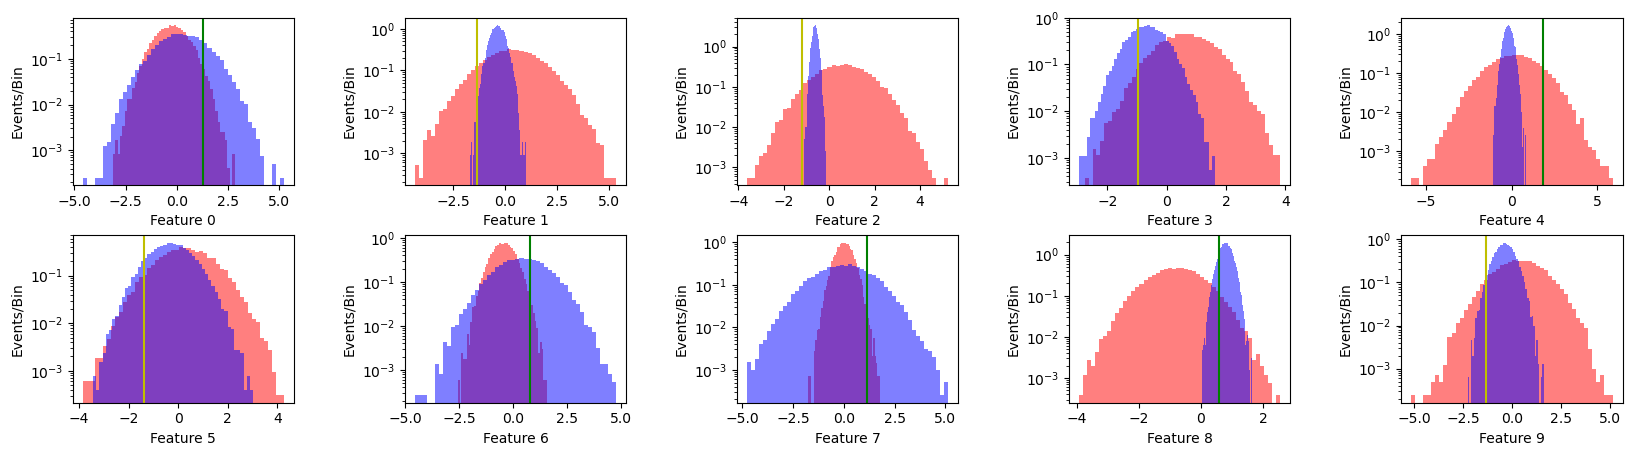

Target efficiency: 70.0%


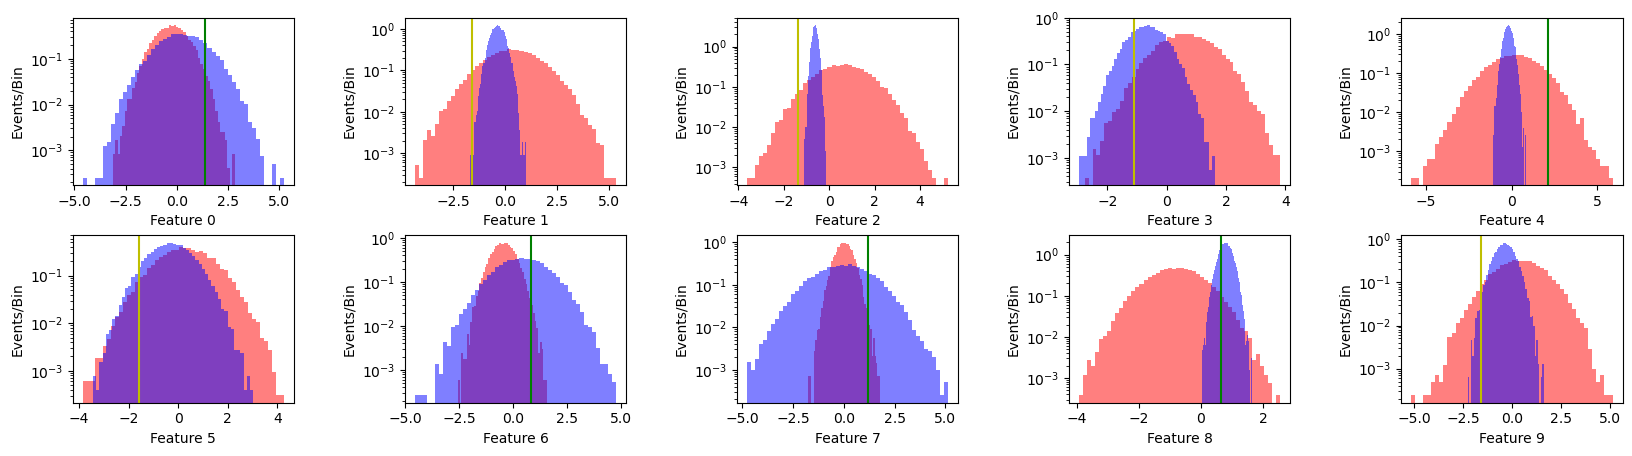

Target efficiency: 80.0%


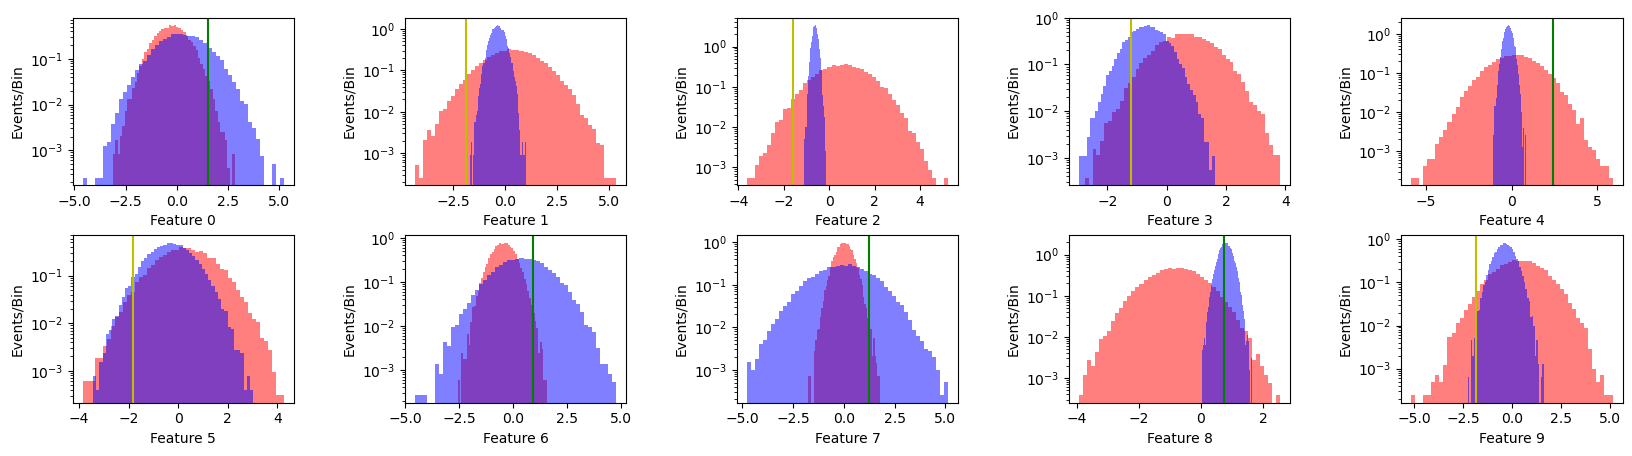

Target efficiency: 90.0%


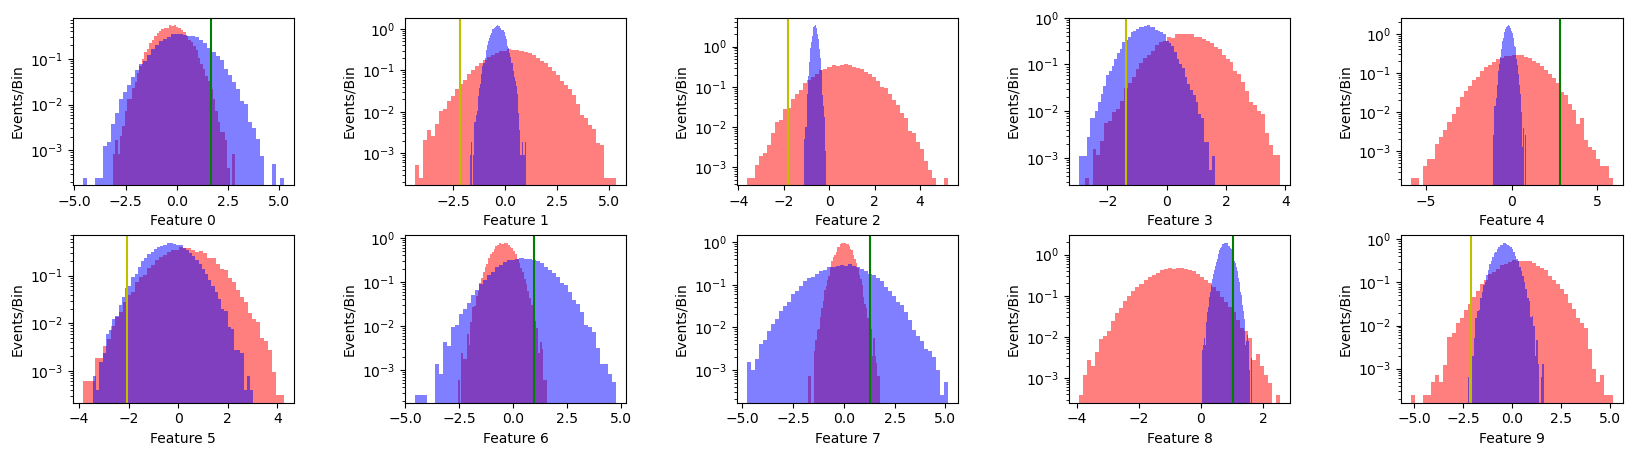

In [16]:
LCU.plotfeatures(net,x_signal,x_backgr,sc)

To do:
* Hyperparameter scan.
* Using real photon ID variables instead of dummies (Scott)
* documentation for LearningCutsUtils
* think more about how to smooth cuts vs pT, the current smoothing procedure is a three-point contraction that seems to be working, but maybe isn't optimal.
* Make a more thorough test of BCE and ATLAS significance to see how they perform.   Check if efficiency-target loss function provides better performance at target efficiency than BCE or ATLAS significance.

In [20]:
import captum
from captum.attr import IntegratedGradients

In [44]:
out_probs = net.nets[-1](x_test_tensor).detach().numpy()

In [46]:
ig = IntegratedGradients(net.nets[-1])

In [48]:
x_test_tensor.requires_grad_()
attr, delta = ig.attribute(x_test_tensor,return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
Feature 0 :  -0.038
Feature 1 :  -0.012
Feature 2 :  -0.005
Feature 3 :  -0.039
Feature 4 :  -0.012
Feature 5 :  -0.011
Feature 6 :  -0.145
Feature 7 :  -0.066
Feature 8 :  -0.055
Feature 9 :  -0.009


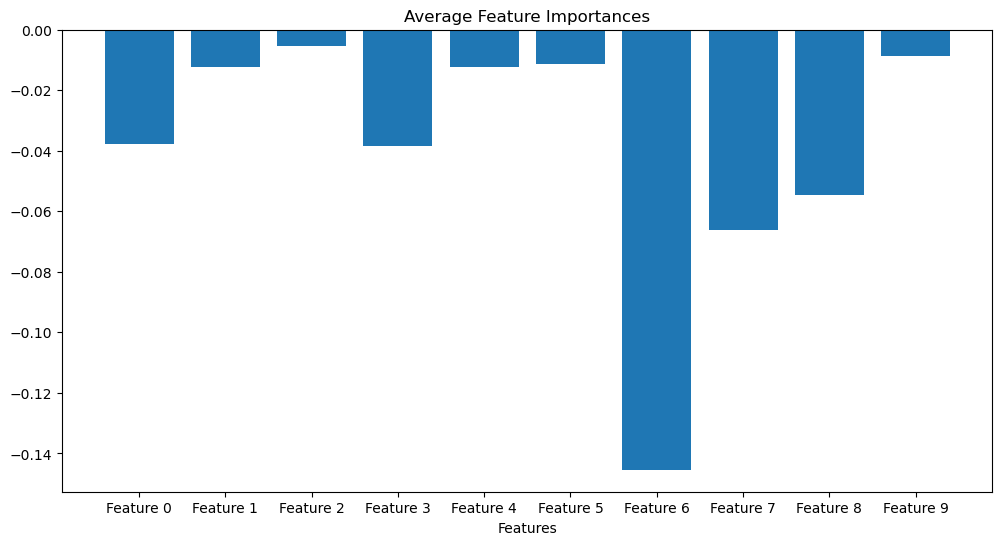

In [49]:
# Helper method to print importances and visualize distribution
feature_names = [f"Feature {i}" for i in range(10)]
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

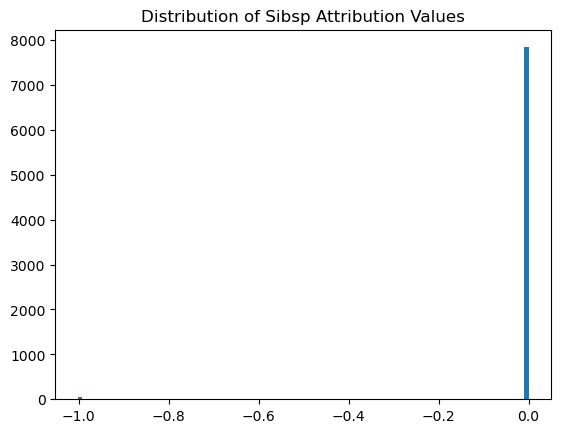

In [51]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

In [52]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

NameError: name 'stats' is not defined